## SVM-LSTM-DS2 

### Managing imports

In [75]:
!pip install tensorflow transformers torch datasets hf_xet

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm



## Without context

#### Dataset 2 preparation

In [77]:
# Only read the first 4400 rows and specific columns
cols_to_use = ['label', 'comment', 'parent_comment']

df2 = pd.read_csv('../Dataset/train-balanced-sarcasm.csv', usecols=cols_to_use, nrows=4400)

# Rename columns
df2 = df2.rename(columns={
    'comment': 'response',
    'parent_comment': 'context'
})

df2

,label,response,context
0,1,That's exactly what a country who made up a ho...,China Tells Trump That Climate Change Is No Ho...
1,1,but it still snows,Facts for those who dispute man-made climate c...
2,0,"lol, you can't make this stuff up.","""Suppression of dissent is about as facist as ..."
3,0,He didn't drink the compliance,"The Worst ""Got Talent"" Judges Go on a Power Trip"
4,0,"In the Half Life series, the reason Gordon Fre...",What 'fan theories' have blown your mind with ...
...,...,...,...
4395,1,"Not to be sexist but uhhhh, stupid women have ...","""Not tryna be racist but uhhh"""
4396,0,He's opposed only when they don't pick him.,Wait wait. Please. Let me stop laughing at the...
4397,0,Round Aboot.,Canadian Solution to SimCity's Round-about Pro...
4398,0,That's some pretty impressive camouflage though.,As a hunter i find this super pathetic.


In [78]:
df2['input_text'] = df2['response'] #+ ' [SEP] ' + df2['context']

# Check the result
print(df2[['input_text', 'label']].head())
print(df2['label'].value_counts())

                                          input_text  label
0  That's exactly what a country who made up a ho...      1
1                                 but it still snows      1
2                 lol, you can't make this stuff up.      0
3                     He didn't drink the compliance      0
4  In the Half Life series, the reason Gordon Fre...      0
label
0    2504
1    1896
Name: count, dtype: int64


In [79]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df2['input_text'], df2['label'],
    test_size=0.2, random_state=42, stratify=df2['label']
)

train_df2 = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df2 = pd.DataFrame({'input_text': X_test, 'label': y_test})


In [80]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)

svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_vec, y_train)

# Save the model and vectorizer for later use
joblib.dump(svm, "../Dataset/temp/svm_model2.joblib")
joblib.dump(vectorizer, "../Dataset/temp/tfidf_vectorizer2.joblib")


['../Dataset/temp/tfidf_vectorizer2.joblib']

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.68       501
           1       0.58      0.56      0.57       379

    accuracy                           0.63       880
   macro avg       0.63      0.63      0.63       880
weighted avg       0.63      0.63      0.63       880



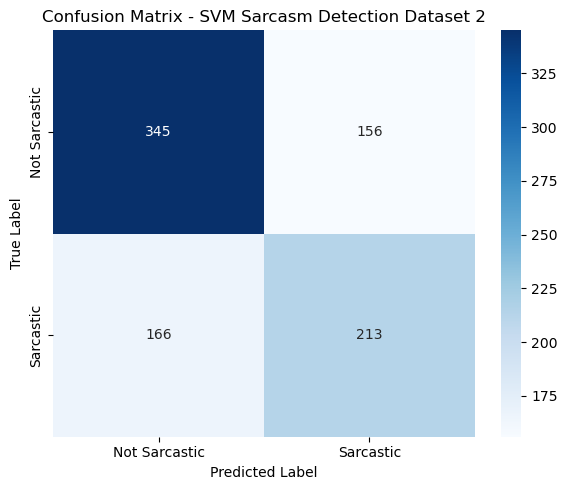

In [81]:
X_test = test_df2['input_text']
y_test = test_df2['label']

vectorizer = joblib.load("../Dataset/temp/tfidf_vectorizer2.joblib")
svm = joblib.load("../Dataset/temp/svm_model2.joblib")

# Transform test data and predict
X_test_vec = vectorizer.transform(X_test)
y_pred = svm.predict(X_test_vec)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Sarcasm Detection Dataset 2')
plt.tight_layout()
plt.show()

### LSTM 

#### Splitting 

In [82]:
X_train_LSTM = train_df2['input_text']
y_train_LSTM = train_df2['label']
X_test_LSTM = test_df2['input_text']
y_test_LSTM = test_df2['label']

max_words = 10000   # Vocabulary size
max_len = 200        # Max sequence length (adjust as needed)

# Fit tokenizer on training data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_LSTM)

# Convert texts to sequences
X_train_seq_LSTM = tokenizer.texts_to_sequences(X_train_LSTM)
X_test_seq_LSTM = tokenizer.texts_to_sequences(X_test_LSTM)

# Pad sequences
X_train_pad_LSTM = pad_sequences(X_train_seq_LSTM, maxlen=max_len, padding='post', truncating='post')
X_test_pad_LSTM = pad_sequences(X_test_seq_LSTM, maxlen=max_len, padding='post', truncating='post')

#### Training

In [83]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
history = model.fit(
    X_train_pad_LSTM, y_train_LSTM,
    epochs=5,             # You can increase epochs if you want
    batch_size=32,
    validation_split=0.1  # Reserve part of train for validation
)


c:\Users\minht\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 294ms/step - accuracy: 0.5729 - loss: 0.6855 - val_accuracy: 0.5483 - val_loss: 0.6900
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.5676 - loss: 0.6855 - val_accuracy: 0.5483 - val_loss: 0.6886
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.5791 - loss: 0.6818 - val_accuracy: 0.5483 - val_loss: 0.6885
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - accuracy: 0.5728 - loss: 0.6835 - val_accuracy: 0.5483 - val_loss: 0.6891
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 344ms/step - accuracy: 0.5816 - loss: 0.6826 - val_accuracy: 0.5483 - val_loss: 0.6887


#### Evaluation

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.5595 - loss: 0.6870
Test Accuracy: 0.5693
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step


c:\Users\minht\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\minht\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\minht\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

Not Sarcastic       0.57      1.00      0.73       501
    Sarcastic       0.00      0.00      0.00       379

     accuracy                           0.57       880
    macro avg       0.28      0.50      0.36       880
 weighted avg       0.32      0.57      0.41       880



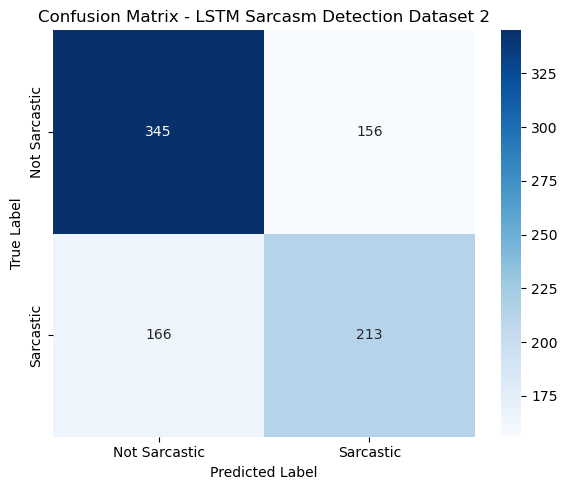

In [84]:
loss, accuracy = model.evaluate(X_test_pad_LSTM, y_test_LSTM)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob_LSTM = model.predict(X_test_pad_LSTM)
y_pred_LSTM = (y_pred_prob_LSTM > 0.5).astype(int).flatten()

print(classification_report(y_test_LSTM, y_pred_LSTM, target_names=['Not Sarcastic', 'Sarcastic']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Sarcasm Detection Dataset 2')
plt.tight_layout()
plt.show()


## With context


In [85]:
df2['input_text'] = df2['response'] + ' [SEP] ' + df2['context']

# Check the result
print(df2[['input_text', 'label']].head())
print(df2['label'].value_counts())

                                          input_text  label
0  That's exactly what a country who made up a ho...      1
1  but it still snows [SEP] Facts for those who d...      1
2  lol, you can't make this stuff up. [SEP] "Supp...      0
3  He didn't drink the compliance [SEP] The Worst...      0
4  In the Half Life series, the reason Gordon Fre...      0
label
0    2504
1    1896
Name: count, dtype: int64


In [86]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df2['input_text'], df2['label'],
    test_size=0.2, random_state=42, stratify=df2['label']
)

train_df2 = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df2 = pd.DataFrame({'input_text': X_test, 'label': y_test})


In [87]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)

svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_vec, y_train)

# Save the model and vectorizer for later use
joblib.dump(svm, "../Dataset/temp/svm_model2.joblib")
joblib.dump(vectorizer, "../Dataset/temp/tfidf_vectorizer2.joblib")


['../Dataset/temp/tfidf_vectorizer2.joblib']

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.70      0.68       501
           1       0.57      0.53      0.55       379

    accuracy                           0.62       880
   macro avg       0.62      0.61      0.61       880
weighted avg       0.62      0.62      0.62       880



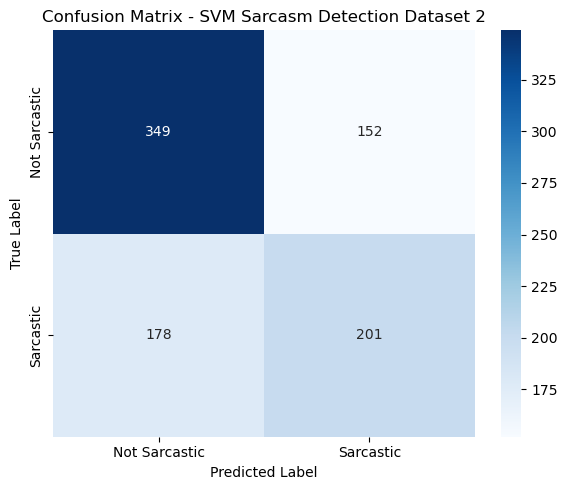

In [88]:
X_test = test_df2['input_text']
y_test = test_df2['label']

vectorizer = joblib.load("../Dataset/temp/tfidf_vectorizer2.joblib")
svm = joblib.load("../Dataset/temp/svm_model2.joblib")

# Transform test data and predict
X_test_vec = vectorizer.transform(X_test)
y_pred = svm.predict(X_test_vec)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Sarcasm Detection Dataset 2')
plt.tight_layout()
plt.show()

### LSTM 

#### Splitting 

In [89]:
X_train_LSTM = train_df2['input_text']
y_train_LSTM = train_df2['label']
X_test_LSTM = test_df2['input_text']
y_test_LSTM = test_df2['label']

max_words = 10000   # Vocabulary size
max_len = 200        # Max sequence length (adjust as needed)

# Fit tokenizer on training data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_LSTM)

# Convert texts to sequences
X_train_seq_LSTM = tokenizer.texts_to_sequences(X_train_LSTM)
X_test_seq_LSTM = tokenizer.texts_to_sequences(X_test_LSTM)

# Pad sequences
X_train_pad_LSTM = pad_sequences(X_train_seq_LSTM, maxlen=max_len, padding='post', truncating='post')
X_test_pad_LSTM = pad_sequences(X_test_seq_LSTM, maxlen=max_len, padding='post', truncating='post')

#### Training

In [90]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
history = model.fit(
    X_train_pad_LSTM, y_train_LSTM,
    epochs=5,             # You can increase epochs if you want
    batch_size=32,
    validation_split=0.1  # Reserve part of train for validation
)


c:\Users\minht\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 333ms/step - accuracy: 0.5706 - loss: 0.6846 - val_accuracy: 0.5483 - val_loss: 0.6887
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 305ms/step - accuracy: 0.5657 - loss: 0.6858 - val_accuracy: 0.5483 - val_loss: 0.6899
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 315ms/step - accuracy: 0.5780 - loss: 0.6830 - val_accuracy: 0.5455 - val_loss: 0.6904
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 35s 249ms/step - accuracy: 0.5947 - loss: 0.6763 - val_accuracy: 0.5426 - val_loss: 0.6905
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 76s 599ms/step - accuracy: 0.5860 - loss: 0.6802 - val_accuracy: 0.5426 - val_loss: 0.6906


#### Evaluation

28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.5555 - loss: 0.6879
Test Accuracy: 0.5625
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.57      0.99      0.72       501
    Sarcastic       0.12      0.00      0.01       379

     accuracy                           0.56       880
    macro avg       0.35      0.49      0.36       880
 weighted avg       0.38      0.56      0.41       880



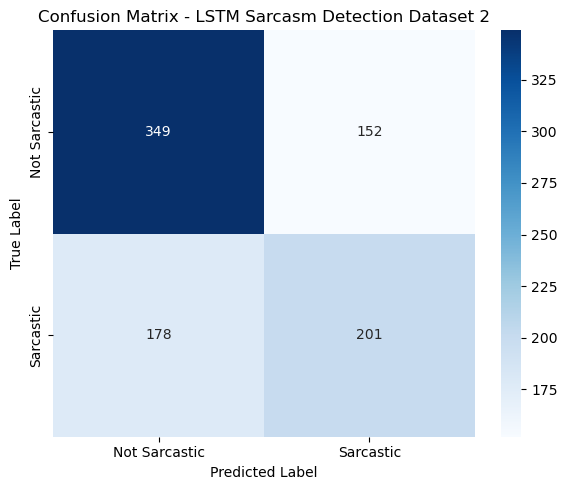

In [91]:
loss, accuracy = model.evaluate(X_test_pad_LSTM, y_test_LSTM)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob_LSTM = model.predict(X_test_pad_LSTM)
y_pred_LSTM = (y_pred_prob_LSTM > 0.5).astype(int).flatten()

print(classification_report(y_test_LSTM, y_pred_LSTM, target_names=['Not Sarcastic', 'Sarcastic']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Sarcasm Detection Dataset 2')
plt.tight_layout()
plt.show()
